In [186]:
import os
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform
from rich.console import Console
from rich.table import Table
from rich.text import Text

# Configurazione di TensorFlow per ridurre l'output non necessario
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Questo rimuove i log informativi e warnings di TensorFlow
tf.get_logger().setLevel(logging.ERROR)

# Ignora i warning
warnings.filterwarnings("ignore")


In [187]:
console = Console()

def printSuccess(message):
    """
    Prints the given message in bright green.
    
    Parameters:
    - message (str): The message to print
    """
    success_text = Text(message, style="bold bright_green")
    console.print(success_text)

def printError(message):
    """
    Prints the given message in bright red.
    
    Parameters:
    - message (str): The message to print
    """
    error_text = Text(message, style="bold bright_red")
    console.print(error_text)

def create_rich_table(title, columns, rows):
    """
    Crea e stampa una tabella formattata con Rich.

    Parameters:
    - title (str): Il titolo della tabella.
    - columns (list of dict): Lista di dizionari, ognuno contenente il nome della colonna e opzioni come 'justify' e 'style'.
      Esempio: [{'header': 'Col1', 'justify': 'right', 'style': 'cyan'}, {...}]
    - rows (list of list): Lista di righe, ognuna contenente i valori delle colonne in ordine.
      Esempio: [['Val1', 'Val2', ...], ['ValA', 'ValB', ...]]
    """
    table = Table(title=title)
    
    # Aggiungi colonne alla tabella
    for col in columns:
        table.add_column(col['header'], justify=col.get('justify', 'center'), style=col.get('style', 'bright_white'))
    
    # Aggiungi righe alla tabella
    for row in rows:
        table.add_row(*row)
    
    # Stampa la tabella
    console.print(table)

# Funzione per stampare i risultati in una tabella con Rich
def print_evaluation_table(val_class_report, test_class_report, val_accuracy, test_accuracy):
    console = Console()
    table = Table(title="Model Evaluation Results")

    # Aggiunta delle colonne
    table.add_column("Metric", style="bright_cyan", no_wrap=True)
    table.add_column("Validation Set", justify="center", style="bright_magenta")
    table.add_column("Test Set", justify="center", style="bright_green")

    # Aggiunta dei risultati
    table.add_row("Accuracy", f"{val_accuracy:.4f}", f"{test_accuracy:.4f}")
    table.add_row("Precision (wgtd_avg)", f"{val_class_report['weighted avg']['precision']:.4f}", f"{test_class_report['0']['precision']:.4f}")
    table.add_row("Recall (wgtd_avg)", f"{val_class_report['weighted avg']['recall']:.4f}", f"{test_class_report['0']['recall']:.4f}")
    table.add_row("F1-Score (wgtd_avg)", f"{val_class_report['weighted avg']['f1-score']:.4f}", f"{test_class_report['0']['f1-score']:.4f}")

    # Stampa della tabella
    console.print(table)

# Stampa dei migliori iperparametri in una tabella con Rich
def print_best_params_table(best_params):
    console = Console()
    table = Table(title="Best Hyperparameters")

    table.add_column("Hyperparameter", style="bright_cyan", no_wrap=True)
    table.add_column("Value", justify="center", style="bright_magenta")

    for param, value in best_params.items():
        table.add_row(param, str(value))

    console.print(table)

In [188]:
# Dizionario globale per memorizzare i risultati dei vari modelli
global_model_results = {}

def save_model_results(model_name, val_class_report, test_class_report, val_accuracy, test_accuracy):
    """
    Salva i risultati del modello nel dizionario globale.
    
    Args:
        model_name (str): Nome del modello (es. 'KNN', 'Random Forest', 'Logistic Regression').
        val_class_report (dict): Report di classificazione per il validation set.
        test_class_report (dict): Report di classificazione per il test set.
        val_accuracy (float): Accuracy sul validation set.
        test_accuracy (float): Accuracy sul test set.
    """
    global global_model_results
    
    # Verifica che i risultati siano specifici per il modello corrente
    model_results = {
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Validation Precision': val_class_report['weighted avg']['precision'],
        'Validation Recall': val_class_report['weighted avg']['recall'],
        'Validation F1-Score': val_class_report['weighted avg']['f1-score'],
        'Test Precision': test_class_report['weighted avg']['precision'],
        'Test Recall': test_class_report['weighted avg']['recall'],
        'Test F1-Score': test_class_report['weighted avg']['f1-score']
    }
    
    # Salva i risultati nel dizionario globale usando il nome del modello come chiave
    global_model_results[model_name] = model_results

In [189]:
def evaluate_and_save_model(model_name, best_model, images_validation, labels_validation, images_testing, labels_testing):
    """
    Esegue la valutazione del modello su validation set e test set, stampa i risultati
    e salva i risultati nel dizionario globale.

    Args:
        model_name (str): Nome del modello (es. 'KNN', 'Random Forest', 'Logistic Regression').
        best_model: Il miglior modello risultante dall'ottimizzazione degli iperparametri.
        images_validation: Immagini del validation set.
        labels_validation: Etichette del validation set.
        images_testing: Immagini del test set.
        labels_testing: Etichette del test set.
    """

    # Appiattimento delle immagini per compatibilità con il modello
    images_validation_flat = images_validation.reshape(images_validation.shape[0], -1)
    images_testing_flat = images_testing.reshape(images_testing.shape[0], -1)

    # Valutazione del modello sul validation set
    y_val_pred = best_model.predict(images_validation_flat)
    val_class_report = classification_report(labels_validation, y_val_pred, output_dict=True)
    val_accuracy = accuracy_score(labels_validation, y_val_pred)

    # Valutazione del modello sul test set
    y_test_pred = best_model.predict(images_testing_flat)
    test_class_report = classification_report(labels_testing, y_test_pred, output_dict=True)
    test_accuracy = accuracy_score(labels_testing, y_test_pred)

    # Stampa dei risultati della valutazione in una tabella formattata
    print_evaluation_table(val_class_report, test_class_report, val_accuracy, test_accuracy)

    # Salvataggio dei risultati nel dizionario globale
    save_model_results(model_name, val_class_report, test_class_report, val_accuracy, test_accuracy)


# Traccia A1 - Riconoscimento di Immagini MNIST-like

L’obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione sul dataset `MedMNIST-Pneumonia`. Questo dataset contiene una collezione di immagini mediche, come radiografie del torace, classificate in base alla presenza (classe 1) o assenza (classe 0) di polmonite.

In questo progetto, procederemo con i seguenti obiettivi:
- Esplorare e visualizzare il dataset per comprendere meglio la natura delle immagini.
- Preprocessare i dati per prepararli all'addestramento.
- Implementare e confrontare diversi modelli di machine learning, partendo da un modello semplice fino a un modello avanzato.
- Valutare le performance dei modelli utilizzando metriche appropriate e interpretare i risultati ottenuti.

![pneumonia](../res/pneumonia.png)


# Visualizzazione Comparativa delle Immagini del Dataset MedMNIST-Pneumonia

In questa sezione, visualizzeremo 8 esempi di immagini estratti dal dataset di interesse, suddivisi in 4 immagini con polmonite (classe 1) e 4 senza polmonite (classe 0). L'obiettivo è fornire un confronto visivo diretto tra le radiografie che mostrano la presenza di polmonite e quelle che non la presentano.

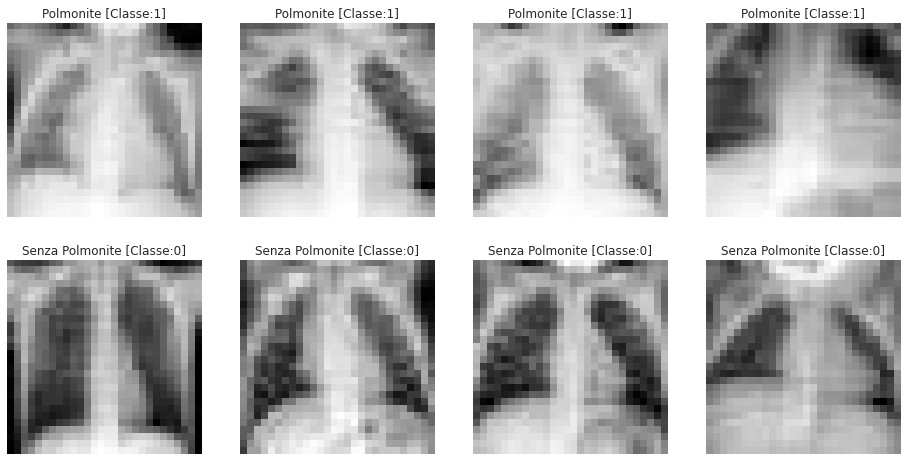

In [190]:
images = np.load("../res/pneumonia_images.npy")
labels = np.load("../res/pneumonia_labels.npy")

indices_with_pneumonia = np.where(labels == 1)[0]
indices_without_pneumonia = np.where(labels == 0)[0]

plt.figure(figsize=(16, 8))

for i in range(4):
    # Immagini con polmonite
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[indices_with_pneumonia[i]], cmap='gray')
    plt.title(f'Polmonite [Classe:{labels[indices_with_pneumonia[i]][0]}]')
    plt.axis('off')

    # Immagini senza polmonite
    plt.subplot(2, 4, i + 5)
    plt.imshow(images[indices_without_pneumonia[i]], cmap='gray')
    plt.title(f'Senza Polmonite [Classe:{labels[indices_without_pneumonia[i]][0]}]')
    plt.axis('off')

plt.show()


# Preparazione dei Dati

In questa sezione, prepareremo i dati per l'addestramento dei modelli. Le fasi principali includeranno:
- **Normalizzazione**: Ridimensionamento dei valori dei pixel in un range [0, 1].
- **Suddivisione dei Dati**: Separazione del dataset in set di training, validation e testing.


In [191]:
# Normalizzazione delle immagini (i valori dei pixel vengono ridotti a [0, 1])
images = images / 255.0

# Suddivisione del dataset in training, validation e testing
images_training, X_temp, labels_training, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
images_validation, images_testing, labels_validation, labels_testing = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Funzione per calcolare le percentuali di classi 0 e 1
def calculate_class_percentages(labels):
    class_0_percentage = (labels == 0).mean() * 100
    class_1_percentage = (labels == 1).mean() * 100
    return class_0_percentage, class_1_percentage

# Calcolo delle percentuali di classi nei vari set
training_class_0, training_class_1 = calculate_class_percentages(labels_training)
validation_class_0, validation_class_1 = calculate_class_percentages(labels_validation)
testing_class_0, testing_class_1 = calculate_class_percentages(labels_testing)

# Flatten the images for compatibility with some models
images_training_flat = images_training.reshape(images_training.shape[0], -1)
images_validation_flat = images_validation.reshape(images_validation.shape[0], -1)
images_testing_flat = images_testing.reshape(images_testing.shape[0], -1)

# Preparazione delle righe per la tabella
rows = [
    ["Training Set", str(images_training.shape[0]), f"{training_class_0:.2f}", f"{training_class_1:.2f}"],
    ["Validation Set", str(images_validation.shape[0]), f"{validation_class_0:.2f}", f"{validation_class_1:.2f}"],
    ["Test Set", str(images_testing.shape[0]), f"{testing_class_0:.2f}", f"{testing_class_1:.2f}"],
    ["TOT", str(images_training.shape[0] + images_validation.shape[0] + images_testing.shape[0]), 
     f"{(training_class_0 + validation_class_0 + testing_class_0) / 3:.2f}", 
     f"{(training_class_1 + validation_class_1 + testing_class_1) / 3:.2f}"]
]

# Definizione delle colonne della tabella
columns = [
    {'header': 'Dataset', 'justify': 'left', 'style': 'bright_magenta'},
    {'header': 'Numero di Immagini', 'justify': 'right', 'style': 'bright_cyan'},
    {'header': 'Classe 0 (%)', 'justify': 'right', 'style': 'bright_green'},
    {'header': 'Classe 1 (%)', 'justify': 'right', 'style': 'bright_red'}
]

# Creazione e visualizzazione della tabella usando l'utility
create_rich_table("Dataset Split Information", columns, rows)

# Stampa separata delle dimensioni delle immagini
print(f"Dimensioni delle Immagini: {images_training.shape[1]}x{images_training.shape[2]}")



                      Dataset Split Information                      
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Dataset        ┃ Numero di Immagini ┃ Classe 0 (%) ┃ Classe 1 (%) ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Training Set   │               3662 │        25.72 │        74.28 │
│ Validation Set │                785 │        28.03 │        71.97 │
│ Test Set       │                785 │        23.82 │        76.18 │
│ TOT            │               5232 │        25.86 │        74.14 │
└────────────────┴────────────────────┴──────────────┴──────────────┘

Dimensioni delle Immagini: 28x28


# Implementazione dei Modelli

Ora procederemo con l'implementazione di diversi modelli di machine learning per affrontare il problema della classificazione muovendoci dai più semplici a quelli più sofisticati per poi metterli a confronto.

## Implementazione dei Modelli di base - KNearestNeighbours

In [199]:
# Definizione dell'intervallo di iperparametri da esplorare
param_dist = {
    'n_neighbors': np.arange(1, 31),  # Numero di vicini da usare
    'weights': ['uniform', 'distance'],  # Funzione di peso usata per la previsione
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Metrica di distanza
    'p': [1, 2, 3],  # Parametro di potenza per la metrica Minkowski
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo usato per trovare i vicini
}

# Inizializzazione del modello KNN
knn_model = KNeighborsClassifier()

# Configurazione di RandomizedSearchCV con cross-validation a 5 fold
random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,  # Numero di configurazioni di parametri campionate
    cv=5,  # Cross-validation a 5 fold
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Esecuzione della ricerca randomizzata sui dati di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("KNN MODEL TRAINED SUCCESSFULLY!")

KNN MODEL TRAINED SUCCESSFULLY!

In [200]:
# Estrazione dei migliori iperparametri
best_params = random_search.best_params_

# Stampa dei migliori iperparametri in una tabella formattata
print_best_params_table(best_params)

     Best Hyperparameters     
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Hyperparameter ┃   Value   ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ weights        │ distance  │
│ p              │     2     │
│ n_neighbors    │     8     │
│ metric         │ manhattan │
│ algorithm      │ ball_tree │
└────────────────┴───────────┘

In [201]:
model_name = "KNN"
best_model = random_search.best_estimator_
evaluate_and_save_model(model_name, best_model, images_validation, labels_validation, images_testing, labels_testing)

print(global_model_results)

              Model Evaluation Results              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric               ┃ Validation Set ┃ Test Set ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Accuracy             │     0.9414     │  0.9643  │
│ Precision (wgtd_avg) │     0.9411     │  0.9441  │
│ Recall (wgtd_avg)    │     0.9414     │  0.9037  │
│ F1-Score (wgtd_avg)  │     0.9406     │  0.9235  │
└──────────────────────┴────────────────┴──────────┘

{'KNN': {'Validation Accuracy': 0.9414012738853503, 'Test Accuracy': 0.9643312101910828, 'Validation Precision': 0.9410706603649188, 'Validation Recall': 0.9414012738853503, 'Validation F1-Score': 0.9406109356989452, 'Test Precision': 0.9640645813860821, 'Test Recall': 0.9643312101910828, 'Test F1-Score': 0.9640598883144613}}


## Implementazione dei Modelli di base - Random Forest

In [202]:
# Definizione del range di iperparametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300],  # Numero di alberi nella foresta
    'max_depth': [10, 20, 30, None],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni richiesti per dividere un nodo
    'min_samples_leaf': [1, 2, 4],  # Numero minimo di campioni che un nodo foglia deve contenere
    'max_features': ['sqrt', 'log2'],  # Numero massimo di caratteristiche considerate per la migliore divisione
    'bootstrap': [True, False],  # Se usare o meno il bootstrap
    'criterion': ['gini', 'entropy'],  # Criterio di divisione
    'class_weight': ['balanced', None]  # Pesi delle classi
}

# Inizializzazione del modello Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurazione della Randomized Search con Cross-Validation (5-fold)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Esecuzione della Randomized Search sul set di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("RANDOM-FOREST MODEL TRAINED SUCCESSFULLY!")

RANDOM-FOREST MODEL TRAINED SUCCESSFULLY!

In [203]:

# Ottenimento dei migliori iperparametri trovati
best_params = random_search.best_params_

# Mostra i migliori iperparametri trovati
print_best_params_table(best_params)

      Best Hyperparameters      
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter    ┃  Value   ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ n_estimators      │   300    │
│ min_samples_split │    2     │
│ min_samples_leaf  │    1     │
│ max_features      │   sqrt   │
│ max_depth         │    30    │
│ criterion         │ entropy  │
│ class_weight      │ balanced │
│ bootstrap         │  False   │
└───────────────────┴──────────┘

In [204]:
model_name = "Random Forest"
best_model = random_search.best_estimator_
evaluate_and_save_model(model_name, best_model, images_validation, labels_validation, images_testing, labels_testing)

print(global_model_results)

              Model Evaluation Results              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric               ┃ Validation Set ┃ Test Set ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Accuracy             │     0.9465     │  0.9516  │
│ Precision (wgtd_avg) │     0.9463     │  0.9408  │
│ Recall (wgtd_avg)    │     0.9465     │  0.8503  │
│ F1-Score (wgtd_avg)  │     0.9458     │  0.8933  │
└──────────────────────┴────────────────┴──────────┘

{'KNN': {'Validation Accuracy': 0.9414012738853503, 'Test Accuracy': 0.9643312101910828, 'Validation Precision': 0.9410706603649188, 'Validation Recall': 0.9414012738853503, 'Validation F1-Score': 0.9406109356989452, 'Test Precision': 0.9640645813860821, 'Test Recall': 0.9643312101910828, 'Test F1-Score': 0.9640598883144613}, 'Random Forest': {'Validation Accuracy': 0.9464968152866242, 'Test Accuracy': 0.9515923566878981, 'Validation Precision': 0.9463145689644075, 'Validation Recall': 0.9464968152866242, 'Validation F1-Score': 0.9457752021599063, 'Test Precision': 0.9512778255551407, 'Test Recall': 0.9515923566878981, 'Test F1-Score': 0.9507274384547935}}


## Implementazione dei Modelli di base - Regressione Logistica

In [205]:
# Definizione del range di iperparametri da esplorare, con filtro delle combinazioni non valide
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': uniform(0.01, 10),
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['saga', 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'newton-cholesky'], 
    'warm_start': [True, False]
}

# Inizializzazione del modello Logistic Regression
logreg_model = LogisticRegression(random_state=42)

# Configurazione di RandomizedSearchCV con cross-validation a 5 fold
random_search = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist,  # Utilizzo diretto di param_dist
    n_iter=30,  # Numero di configurazioni di parametri campionate
    cv=5,  # Cross-validation a 5 fold
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Esecuzione della ricerca randomizzata sui dati di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("LOGISTIC-REGRESSION MODEL TRAINED SUCCESSFULLY!")

/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linea

LOGISTIC-REGRESSION MODEL TRAINED SUCCESSFULLY!

In [206]:
# Estrazione dei migliori iperparametri
best_params = random_search.best_params_

# Stampa dei migliori iperparametri in una tabella formattata
print_best_params_table(best_params)

         Best Hyperparameters          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃       Value        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ C              │ 2.9314464853521813 │
│ class_weight   │        None        │
│ fit_intercept  │        True        │
│ penalty        │         l2         │
│ solver         │  newton-cholesky   │
│ warm_start     │        True        │
└────────────────┴────────────────────┘

In [207]:
model_name = "Logistic Regression"
best_model = random_search.best_estimator_
evaluate_and_save_model(model_name, best_model, images_validation, labels_validation, images_testing, labels_testing)

print(global_model_results)

              Model Evaluation Results              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric               ┃ Validation Set ┃ Test Set ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Accuracy             │     0.9554     │  0.9669  │
│ Precision (wgtd_avg) │     0.9552     │  0.9399  │
│ Recall (wgtd_avg)    │     0.9554     │  0.9198  │
│ F1-Score (wgtd_avg)  │     0.9550     │  0.9297  │
└──────────────────────┴────────────────┴──────────┘

{'KNN': {'Validation Accuracy': 0.9414012738853503, 'Test Accuracy': 0.9643312101910828, 'Validation Precision': 0.9410706603649188, 'Validation Recall': 0.9414012738853503, 'Validation F1-Score': 0.9406109356989452, 'Test Precision': 0.9640645813860821, 'Test Recall': 0.9643312101910828, 'Test F1-Score': 0.9640598883144613}, 'Random Forest': {'Validation Accuracy': 0.9464968152866242, 'Test Accuracy': 0.9515923566878981, 'Validation Precision': 0.9463145689644075, 'Validation Recall': 0.9464968152866242, 'Validation F1-Score': 0.9457752021599063, 'Test Precision': 0.9512778255551407, 'Test Recall': 0.9515923566878981, 'Test F1-Score': 0.9507274384547935}, 'Logistic Regression': {'Validation Accuracy': 0.9554140127388535, 'Test Accuracy': 0.9668789808917198, 'Validation Precision': 0.9552216192758021, 'Validation Recall': 0.9554140127388535, 'Validation F1-Score': 0.9549888544395562, 'Test Precision': 0.9666996568351801, 'Test Recall': 0.9668789808917198, 'Test F1-Score': 0.96675515005

# Confronto modelli di base

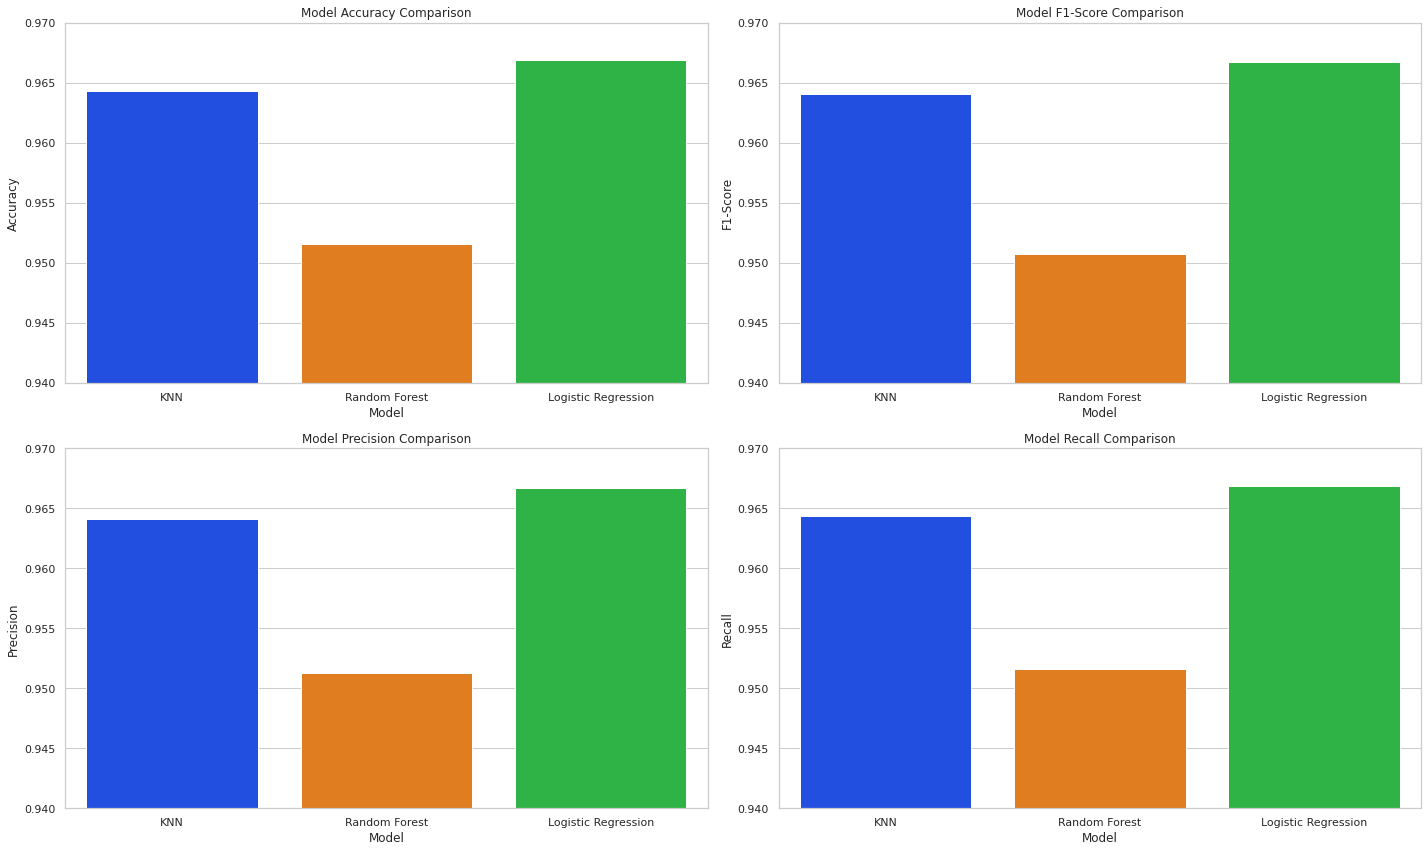

In [219]:
# Supponiamo che global_model_results sia già popolato con i risultati dei modelli
# Converti i risultati in un DataFrame per un confronto più semplice
df_results = pd.DataFrame(global_model_results).transpose()

# Reset index per avere i nomi dei modelli come colonna
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Model'}, inplace=True)

# Configurazione dello stile del grafico
sns.set(style="whitegrid")
palette = sns.color_palette("bright", len(df_results))

# Creazione di un grafico a barre multiple per confrontare le metriche principali
plt.figure(figsize=(20, 12))

yLim = (0.94, 0.97)

# Accuracy plot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Test Accuracy', data=df_results, palette=palette)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(yLim)

# F1-Score plot
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Test F1-Score', data=df_results, palette=palette)
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(yLim)

# Precision plot
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Test Precision', data=df_results, palette=palette)
plt.title('Model Precision Comparison')
plt.ylabel('Precision')
plt.ylim(yLim)

# Recall plot
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Test Recall', data=df_results, palette=palette)
plt.title('Model Recall Comparison')
plt.ylabel('Recall')
plt.ylim(yLim)

# Regolazione del layout e visualizzazione del grafico
plt.tight_layout()
plt.show()

## Implementazione del Modello Intermedio - LeNET
